#### I. Referencias consultadas

# Desarrollo numérico para resolver la ecuación de Schrödinger dependiente del tiempo mediante el problema de autovalores

## 1. Importamos módulo con funciones, parámetros y algorítmos útiles

In [5]:
name_code = "02_Code";

In [6]:
include("../modules/module_schrodinger_equation_eigenproblem.jl"); # módulo para construir grilla (1D)

  Activating project at `~/github_repositories/my_repositories/ElectronNuclear_Coupling_Dynamics/gridap_makie`


Primero mostramos cómo se creo el potencial tipo finite well potential para calculo de autovalores

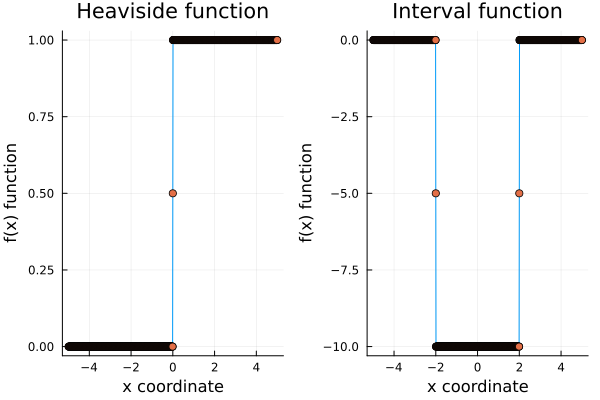

In [7]:
using Plots

xₐ=-5.0;xᵦ=5.0;Δx=abs(xᵦ-xₐ)*(1.0/1000.0);
x=[xₐ+Δx*i for i in 1:1000]

plt21=plot()

plt2=plot!(plt21,x,heaviside.(x),label="")
plt2=scatter!(plt21,x,heaviside.(x),label="")
plt2=plot!(xlabel="x coordinate",ylabel="f(x) function")
plt2=plot!(title="Heaviside function")

plt31=plot()
plt3=plot!(plt31,x,interval.(x,-2,2,-10),label="")
plt3=scatter!(plt31,x,interval.(x,-2,2,-10),label="")
plt3=plot!(xlabel="x coordinate",ylabel="f(x) function")
plt3=plot!(title="Interval function")

plt5=plot(plt2,plt3,layout=2)

display(plt5)

## 2. Creamos propiedades de la grilla

* Tipo de grilla
* Discretización espacial
* Dominio
* Condiciones de contorno

In [10]:
grid_type="simple_line";                            # tipo de grilla
ΔxH=1.0/800.0;                                      # tamaño del elento 1D

dom_1D=(-25.0,25.0);

par_1D=(path_models,grid_type*"_01",dom_1D,ΔxH);    # (path,name,dom,MeshSize)

model_1D=make_model(grid_type,par_1D);              # creamos modelo

# condiciones de contorno
dirichlet_tags_1D=["left_point","right_point"];
dirichlet_values_1D=[0.0,0.0];

Ω_1D,dΩ_1D,Γ_1D,dΓ_1D=measures(model_1D,3,dirichlet_tags_1D);
reffe_1D=reference_FEspaces(lagrangian,Float64,2);

Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Done meshing 1D (Wall 0.031165s, CPU 0.030365s)
Info    : 40001 nodes 40002 elements
Info    : Writing '../outputs/02_Code/models/simple_line_01.msh'...
Info    : Done writing '../outputs/02_Code/models/simple_line_01.msh'
Info    : Reading '../outputs/02_Code/models/simple_line_01.msh'...
Info    : 3 entities
Info    : 40001 nodes
Info    : 40002 elements
Info    : Done reading '../outputs/02_Code/models/simple_line_01.msh'


In [11]:
x,pts=space_coord(dom_1D,ΔxH);

## 3. Metodo de autovalores

La idea acá es resolver el problema de autovalores para el hamiltoniano $\hat {h}(x)$. Los espacios Test y Trial son reales, y no complejos, entonces buscamos obtener las partes reales e imaginarias de los autoestados por separado. 

El sistema se reduce a una ecuación de Sturm-Liouville con parámetros $p( x) ,q( x) ,r( x)$ defnidos como,

\begin{align}
    \begin{cases}
    p( x) =\frac{\hbar ^{2}}{2m}\\
    q(x) =\begin{cases} 0 & | x| \gt  a \\ -V_{0} & | x| \le  a \end{cases}\\
    r( x) =1
    \end{cases} \Rightarrow -\frac{d}{dx}\left( p( x)\frac{d}{dx}\right) +q( x)\begin{pmatrix}
    u_{1}( x)\\
    u_{2}( x)
    \end{pmatrix} =\lambda r( x)\begin{pmatrix}
    u_{1}( x)\\
    u_{2}( x)
    \end{pmatrix}
\end{align}

### 3.1. Resolvemos problema de autovalores para $\hat {h}_{x_0=0}(x)$

Definimos los espacios Test y Trial y construimos las formas bilineales

Las formas bilineales para considerar el problema débil de autovalores serán de la forma,

\begin{align}
    \begin{array}{l}
    \begin{cases}
    a_{1}( u_{1} ,v_{1}) := \int _{\Omega }[ p( x)( \nabla v_{1} \cdotp \nabla u_{1}) +q( x)( v_{1} u_{1})] d\Omega \\
    a_{2}( u_{2} ,v_{2}) := \int _{\Omega }[ p( x)( \nabla v_{2} \cdotp \nabla u_{2}) +q( x)( v_{2} u_{2})] d\Omega 
    \end{cases}\\
    a(( u_{1} ,u_{2}) ,( v_{1} ,v_{2})) := a_{1}( u_{1} ,v_{1}) +a_{2}( u_{2} ,v_{2})\\
    \\
    \begin{cases}
    b_{1}( u_{1} ,v_{1}) := \int _{\Omega } r( x)( v_{1} u_{1}) d\Omega ; & b_{2}( u_{2} ,v_{2}) := \int _{\Omega } r( x)( v_{2} u_{2}) d\Omega 
    \end{cases}\\
    b(( u_{1} ,u_{2}) ,( v_{1} ,v_{2})) := b_{1}( u_{1} ,v_{1}) +b_{2}( u_{2} ,v_{2})
    \end{array}
\end{align}

In [12]:
Vₕre_1D=TestFESpace(model_1D,reffe_1D;vector_type=Vector{Float64},conformity=:H1,dirichlet_tags=dirichlet_tags_1D);
Uₕre_1D=TrialFESpace(Vₕre_1D,dirichlet_values_1D);
Vₕim_1D=TestFESpace(model_1D,reffe_1D;vector_type=Vector{Float64},conformity=:H1,dirichlet_tags=dirichlet_tags_1D);
Uₕim_1D=TrialFESpace(Vₕim_1D,dirichlet_values_1D);
Uₕ_1D = MultiFieldFESpace([Uₕre_1D, Uₕim_1D]);
Vₕ_1D = MultiFieldFESpace([Vₕre_1D, Vₕim_1D]);

V₀_FWP=-5.0;a_FWP=10.0;

pₕ,qₕ,rₕ=eigenvalue_problem_functions((V₀_FWP,a_FWP);switch_potential = "FWP")
aₕ_1D,bₕ_1D=bilineal_forms_ReImParts(pₕ,qₕ,rₕ,dΩ_1D;switch_potential = "FWP");

Set quantum finite well potential


Construimos el problema de autovalores, con parámetros específicos de resolución

In [13]:
nevₕ=8; # debe ser múltiplo de 2
probₕ_1D=EigenProblem(aₕ_1D,bₕ_1D,Uₕ_1D,Vₕ_1D;nev=nevₕ,tol=10^(-9),maxiter=300,explicittransform=:none,sigma=V₀_FWP);

Resolvermos el problema, para obtener autovalores y autoestados

In [14]:
ϵₕ_1D,ϕₕ_1D=solve(probₕ_1D);

Y ahora guardamos la parte real e imaginaria de los autoestados en un único autoestado complejo. Para ello deberemos definir nuevos espacios Test y Trial complejos.

Como los autoestados de la parte real e imaginaria asociadas a un mismo autoestado son degenerados, tendremos que saltear de a 2 (grado de degeneración) los datos obtenidos para no duplicar resultados y quedarnos con sólo aquellos resultados no triviales.

In [18]:
Vₕreim_1D=TestFESpace(model_1D,reffe_1D;vector_type=Vector{ComplexF64},conformity=:H1,dirichlet_tags=dirichlet_tags_1D);
Uₕreim_1D=TrialFESpace(Vₕreim_1D,dirichlet_values_1D);

ϕₕreim_1D=Vector{CellField}(undef,convert(Int32,probₕ_1D.nev/2));

for i in 1:2:probₕ_1D.nev
    fₕ_1D=interpolate_everywhere(ϕₕ_1D[i],probₕ_1D.trial);
    fₕre_1D,fₕim_1D=fₕ_1D;
    ϕₕreim_1D[convert(Int32,(i+1)/2)]=interpolate_everywhere(fₕre_1D+im*fₕim_1D,Uₕreim_1D);
end

Verificamos la normalización de los autoestados, para ello usando la función anterior y deberíamos obtener resultados cercanos a la unidad

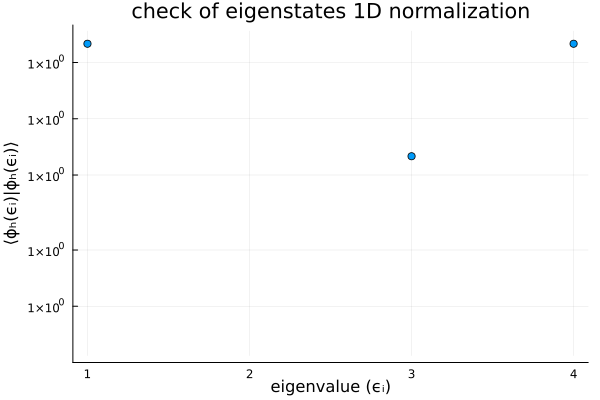

In [19]:
plotting=true
if plotting
    ϕₕreim_1D_norm=normalization_eigenstates_1D(ϕₕreim_1D,Uₕreim_1D,dΩ_1D);
    plot₁=plot()
    plot₁=scatter!([i for i in 1:length(ϕₕreim_1D)],ϕₕreim_1D_norm,label="")
    plot₁=plot!(xlabel="eigenvalue (ϵᵢ)",ylabel="⟨ϕₕ(ϵᵢ)|ϕₕ(ϵᵢ)⟩")
    plot₁=plot!(title="check of eigenstates 1D normalization")
    display(plot₁)
end

Ahora podemos graficar los diferentes autoestados

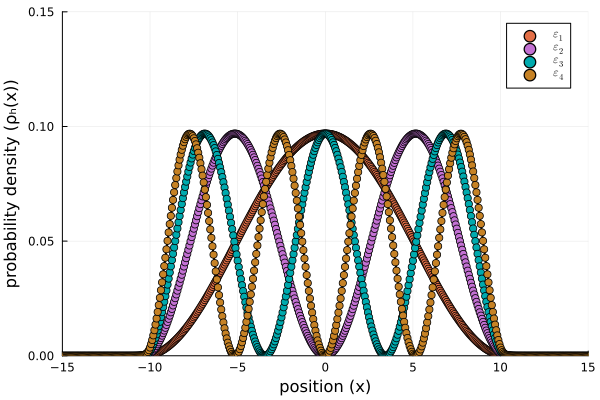

In [20]:
plotting=true
if plotting
    plot1=plot()
    ρₕreim_1D=zeros(Float64,length(pts))
    for i in [1,2,3,4]
        ρₕreim_1D=real(conj(ϕₕreim_1D[i].(pts)).*(ϕₕreim_1D[i].(pts)))
        plot1=plot!(x,ρₕreim_1D,label="",lw=2,lc=:"black",ylim=(0,0.15),xlim=(-15,15))
        plot1=scatter!(x,ρₕreim_1D,label="\$ \\epsilon_{$(i)}\$",lw=0.1,ylim=(0,0.15),xlim=(-15,15))
        plot1=plot!(xlabel="position (x)",ylabel="probability density (ρₕ(x))")
    end

    plot3=plot(plot1)
    display(plot3)
    # savefig(plot3,path_plots*"density_eigenstates_FWP_individual.pdf");
end

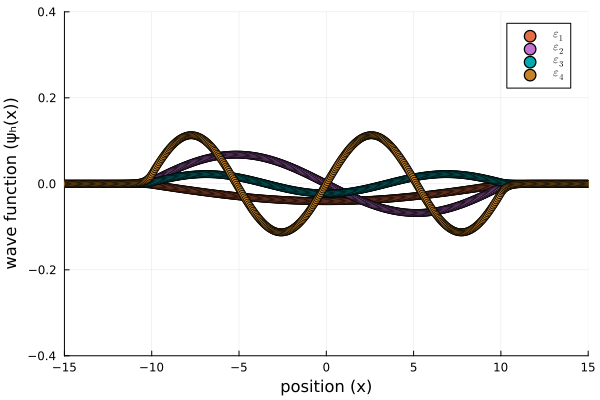

In [21]:
plotting=true
if plotting
    plot1=plot()
    ρₕreim_1D=zeros(Float64,length(pts))
    for i in [1,2,3,4]
        ψₕreim_1D=real(ϕₕreim_1D[i].(pts))
        plot1=plot!(x,ψₕreim_1D,label="",lw=2,lc=:"black",ylim=(-0.4,0.4),xlim=(-15,15))
        plot1=scatter!(x,ψₕreim_1D,label="\$ \\epsilon_{$(i)}\$",lw=0.1,ylim=(-0.4,0.4),xlim=(-15,15))
        plot1=plot!(xlabel="position (x)",ylabel="wave function (ψₕ(x))")
    end

    plot3=plot(plot1)
    display(plot3)
    # savefig(plot3,path_plots*"eigenstates_FWP_individual.pdf");
end

De la misma forma que para los autoestados debemos retener sólo algunos resultados de los autovalores obtenidos, recordando la degeneración de las partes real e imaginaria asociadas a un mismo autoestado.

In [22]:
ϵₕ₁re_1D=ϵₕ_1D[1:2:end];                        # vector de autovalores (SIN DEGENERACIÓN)
ϵₕ₁re_1D_exact=[-4.98841,-4.95364,-4.89569,-4.8146];    # vector de autovalores exactos (para a=10 y V0=-5)

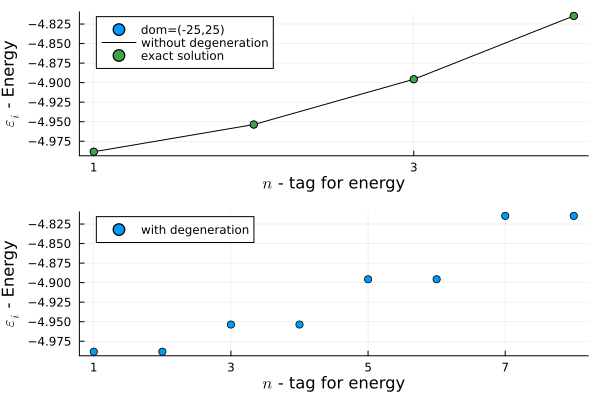

In [23]:
plotting=true

if plotting
    plot1=scatter([i for i in 1:nevₕ/2],ϵₕ₁re_1D,label="dom=(-25,25)",xlabel="\$n\$ - tag for energy",ylabel="\$\\epsilon_i\$ - Energy",xticks=(1:2:nevₕ),lw=2)
    plot1=plot!([i for i in 1:nevₕ/2],ϵₕ₁re_1D,label="without degeneration",lc=:"black",lw=1)
    plot1=scatter!([i for i in 1:nevₕ/2],ϵₕ₁re_1D_exact,label="exact solution",lc=:"red",lw=1)
    plot1=plot!(legend=:topleft)

    plot2=scatter([i for i in 1:nevₕ],ϵₕ_1D,label="with degeneration")
    plot2=plot!(xlabel="\$n\$ - tag for energy",ylabel="\$\\epsilon_i\$ - Energy",xticks=(1:2:nevₕ),lw=2)
    plot2=plot!(legend=:topleft)

    plot3=plot(plot1,plot2,layout=(2,1))
    # savefig(plot3,path_plots*"eigenvalues_QHO_individual.pdf");
    display(plot3)
end

### 3.2. Resolvemos problema de autovalores para $\hat {h}_{x_0=0}(x)$ variando el tamaño de los elementos finitos $\Delta x$

In [32]:
include("../modules/module_schrodinger_equation_eigenproblem_v2.jl"); # módulo para construir grilla (1D)

  Activating project at `~/github_repositories/my_repositories/ElectronNuclear_Coupling_Dynamics/gridap_makie`


In [34]:
# CONFIGURAMOS INPUT/OUTPU JULIA
rm("../outputs/01_Code/energy_vs_FE_FWP.dat")
io_10 = open("../outputs/01_Code/energy_vs_FE_FWP.dat", "w");
space="  ";
write(io_10, "#level$(space)ϵ_exact$(space)ϵₕ[au]$(space)ΔxH[au]\n");

# CREAMOS PROPIEDADES DE LA GRILLA

grid_type="simple_line";    # mesh type

dom_1D=(-25.0,25.0);

# condiciones de contorno
dirichlet_tags_1D=["left_point","right_point"];
dirichlet_values_1D=[0.0,0.0];

reffe_1D=reference_FEspaces(lagrangian,Float64,2);

nevₕ=6; # debe ser múltiplo de 2

V₀_FWP=-5.0;a_FWP=10.0;

pₕ,qₕ,rₕ=eigenvalue_problem_functions((V₀_FWP,a_FWP);switch_potential = "FWP")

for ΔxH_index in 1:50

    ΔxH=2.5*(1.0/ΔxH_index); # max range domain

    par_1D=(path_models,grid_type*"_01",dom_1D,ΔxH);    # (path,name,dom,MeshSize)

    model_1D=make_model(grid_type,par_1D);              # creamos modelo

    Ω_1D,dΩ_1D,Γ_1D,dΓ_1D=measures(model_1D,3,dirichlet_tags_1D);

    # RESOLVEMOS PROBLEMA DE AUTOVALORES PARA h
    Vₕre_1D=TestFESpace(model_1D,reffe_1D;vector_type=Vector{Float64},conformity=:H1,dirichlet_tags=dirichlet_tags_1D);
    Uₕre_1D=TrialFESpace(Vₕre_1D,dirichlet_values_1D);
    Vₕim_1D=TestFESpace(model_1D,reffe_1D;vector_type=Vector{Float64},conformity=:H1,dirichlet_tags=dirichlet_tags_1D);
    Uₕim_1D=TrialFESpace(Vₕim_1D,dirichlet_values_1D);
    Uₕ_1D = MultiFieldFESpace([Uₕre_1D, Uₕim_1D]);
    Vₕ_1D = MultiFieldFESpace([Vₕre_1D, Vₕim_1D]);
    aₕ_1D,bₕ_1D=bilineal_forms_ReImParts(pₕ,qₕ,rₕ,dΩ_1D;switch_potential = "FWP");
    probₕ_1D=EigenProblem(aₕ_1D,bₕ_1D,Uₕ_1D,Vₕ_1D;nev=nevₕ,tol=10^(-9),maxiter=300,explicittransform=:none,sigma=V₀_FWP);
    ϵₕ_1D,ϕₕ_1D=solve(probₕ_1D);

    ϵₕ₁re_1D=ϵₕ_1D[1:2:end]; # vector de autoestados (SIN DEGENERACIÓN)

    for i in 1:length(ϵₕ₁re_1D)
        write(io_10,"$(i)$(space)$(ϵₕ₁re_1D_exact[i])$(space)$(ϵₕ₁re_1D[i])$(space)$(ΔxH)\n");
    end
end

close(io_10)

Set quantum finite well potential
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Done meshing 1D (Wall 0.00024448s, CPU 0.000239s)
Info    : 21 nodes 22 elements
Info    : Writing '../outputs/01_Code/models/simple_line_01.msh'...
Info    : Done writing '../outputs/01_Code/models/simple_line_01.msh'
Info    : Reading '../outputs/01_Code/models/simple_line_01.msh'...
Info    : 3 entities
Info    : 21 nodes
Info    : 22 elements
Info    : Done reading '../outputs/01_Code/models/simple_line_01.msh'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Done meshing 1D (Wall 0.000152553s, CPU 0.000155s)
Info    : 41 nodes 42 elements
Info    : Writing '../outputs/01_Code/models/simple_line_01.msh'...
Info    : Done writing '../outputs/01_Code/models/simple_line_01.msh'
Info    : Reading '../outputs/01_Code/models/simple_line_01.msh'...
Info    : 3 entities
Info    : 41 nodes
Info    : 42 elements
Info    : Done reading '../outputs/01_Code/models/simple_line_0

In [1]:
# todo lo que sigue es para visualizar una página .pdf en Jupiter Notewook

# instalar paquete si no está intalado aún
import Pkg; Pkg.add("PGFPlotsX");
# Create a PDF struct that can be showed as inline svg
using PGFPlotsX

struct PDF
    file::String
    PDF(file) = new(abspath(file))
end
function Base.show(io::IO, ::MIME"image/svg+xml", pdf::PDF)
    svg = first(splitext(pdf.file)) * ".svg"
    #svg = splitext(pdf.file) * ".svg"
    PGFPlotsX.convert_pdf_to_svg(pdf.file, svg)
    write(io, read(svg))
    try; rm(svg; force=true); catch e; end
    return nothing
end

    Updating registry at `~/.julia/registries/General.toml`


   Resolving package versions...


  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


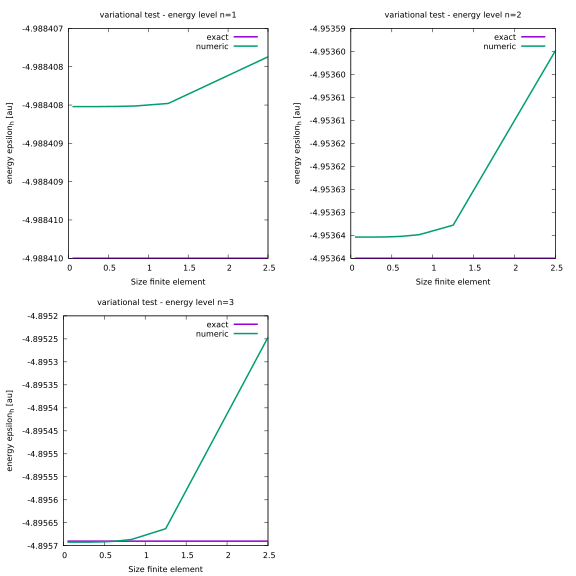

In [4]:
PDF("../outputs/02_Code/result_plot_energy_vs_FE_FWP.pdf")